In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import re
import ast
import string
import unidecode
from collections import defaultdict
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, concatenate, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk import word_tokenize
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
with open("../data/word2idx/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
    #Map any unknown word to UNKNOWN, which has index 1

In [3]:
len(word2idx)

445881

In [4]:
data = pd.read_csv('../data/sample_data_1percent.csv')

In [5]:
data.head()

,text,link_anchor,link_start,link_end,target_wikidata,tokenized_vector,candidates
0,the academy awards also officially and popular...,film industry,120,133,1415395,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[93196.0, 2973146.0, 2973208.0, 2973157.0, 328..."
1,the academy awards also officially and popular...,academy of motion picture arts and sciences,156,199,212329,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[212329.0, 212329.0]"
2,the academy awards also officially and popular...,art deco,551,559,173782,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[173782.0, 4824850.0, 4796770.0, 23307613.0, 2..."
3,the academy awards also officially and popular...,george stanley,603,617,5544783,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[3101928.0, 5539480.0, 5544780.0, 5544779.0, 5..."
4,the academy awards also officially and popular...,cedric gibbons,642,656,727904,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[727904.0, 5057103.0]"


In [11]:
conditions = data.link_anchor.str.match('^#+$', na=False)
data = data[~conditions]
data = data.reset_index().drop('index', axis=1)

In [27]:
j = 36308
data.iloc[j]

text                in spanish football the trofeo pichichi is awa...
link_anchor                                             ###### season
link_start                                                        236
link_end                                                          249
target_wikidata                                                430774
tokenized_vector    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
candidates          [289165.0, 817255.0, 338385.0, 817262.0, 18898...
Name: 36308, dtype: object

In [28]:
data.iloc[j].text

'in spanish football the trofeo pichichi is awarded by the sports newspaper marca to the top goalscorer of each la liga season named after the athletic bilbao striker rafael pichichi moreno the trophy has been awarded annually since the ###### season all top scorers who preceded the awards creation were retroactively named pichichi winners by marca since the ###### season the top scorer of the liga iberdrola is also awarded the pichichi trophy the pichichi is not officially recognised by the leagues governing body the liga de futbol profesional lfp as the award is based on marcas subjective criteria its data may differ from the official match delegate reports for the top scorers in la liga according to lfp data see list of la liga top scorers the players with the most wins are spanish player telmo zarra and argentine player lionel messi with six'

In [29]:
data.iloc[j].text[data.iloc[j].link_start-5: data.iloc[j].link_end+5]

' the ###### season all '

In [30]:
data.iloc[j].candidates

'[289165.0, 817255.0, 338385.0, 817262.0, 1889807.0, 929805.0, 1760157.0, 776728.0, 2271507.0, 377382.0, 456869.0, 1949686.0, 2181967.0, 960028.0, 687048.0, 704091.0, 704077.0, 819042.0, 1085970.0, 120467.0, 1754481.0, 16826129.0, 1888011.0, 4570633.0, 4571813.0, 4572610.0, 4573011.0, 4573426.0, 4573862.0, 4574394.0, 4574900.0, 4575959.0, 4576494.0, 4577032.0, 4577523.0, 16826803.0, 4578557.0, 15987508.0, 4580250.0, 4581501.0, 4583501.0, 4584244.0, 4584995.0, 4586623.0, 4603774.0, 4588279.0, 4589160.0, 3356854.0, 4591090.0, 17163344.0, 936020.0, 638881.0, 1085961.0, 2028129.0, 837731.0, 4603835.0, 4602386.0, 4600993.0, 841303.0, 225273.0, 841266.0, 533191.0, 18995.0, 628453.0, 833562.0, 1436231.0, 581336.0, 1078228.0, 4600908.0, 386017.0, 1889836.0, 1773283.0, 1926018.0, 2431757.0, 4556792.0, 2255286.0, 2434534.0, 369462.0, 4603782.0, 3921717.0, 221316.0, 304338.0, 592630.0, 695361.0, 698120.0, 695331.0, 700494.0, 695357.0, 700458.0, 600681.0, 687247.0, 700477.0, 705462.0, 708100.0, 29

In [16]:
list_lens = [0]*300
num_nan = 0
for i, lst in data.candidates.iteritems():
    #if np.isnan(l):
    #    num_nan += 1
    if not type(lst) == str and np.isnan(lst):
        num_nan += 1
        continue
    l = ast.literal_eval(lst)
    try:
        list_lens[len(l)] += 1
    except IndexError:
        print(i, len(l))

133 355
252 431
683 431
821 355
843 325
912 444
913 357
915 375
1099 431
1193 355
1217 804
1375 367
1482 355
1487 335
1566 379
1633 444
1654 414
1752 431
1856 414
1886 413
1968 655
1969 1620
1970 1620
1971 1620
1975 655
2113 414
2137 444
2138 325
2157 413
2229 444
2230 367
2235 414
2271 379
2404 444
2613 444
2614 379
2615 367
2981 375
3065 2448
3084 431
3092 325
3504 413
3942 414
4000 387
4055 414
4094 413
4429 444
4430 357
4497 414
4526 325
4645 355
4665 444
4672 431
4712 444
4767 357
4776 355
4850 414
4890 431
4892 325
4893 375
4894 367
4896 355
4899 414
4954 444
4958 367
4959 379
4961 444
4964 357
4973 414
4996 414
5111 414
5147 367
5251 414
5252 375
5253 444
5254 379
5268 355
5280 414
5287 414
5289 375
5307 413
5515 303
5606 804
5780 379
5839 357
5845 357
5921 1620
5922 1620
6284 367
6390 375
6392 375
6398 414
6790 444
6791 367
7084 379
7270 355
7327 413
7473 444
7487 477
7491 477
7495 477
7521 4014
7523 335
8044 2448
8059 414
8067 414
8077 431
8218 580
8256 444
8319 375
8327 414
8

84425 4014
84537 396
84543 367
84590 414
84598 325
84603 375
84690 367
84776 367
84959 444
84960 357
85042 367
85138 1620
85164 408
85225 1620
85275 375
85383 1620
85387 1620
85432 414
85494 414
85495 375
85556 431
85589 444
85797 408
85831 375
85889 408
86331 4014
86347 351
86369 414
86411 414
86499 431
86556 375
86565 413
86608 414
86654 1620
86655 1620
86656 1620
86660 1620
86661 1620
86662 1620
86663 1620
86664 1620
86808 444
87099 414
87118 414
87130 344
87159 414
87187 414
87207 414
87211 483
87216 414
87313 414
87353 414
87383 414
87455 559
87518 313
87613 367
87618 379
87689 355
87928 414
87929 375
88039 804
88131 325
88132 431
88254 375
88286 367
88373 355
88416 431
88418 726
88424 444
88428 431
88432 379
88437 375
88439 355
88440 357
88441 414
88535 431
88614 431
88656 444
88847 431
88866 355
88878 483
88890 413
89535 367
89664 413
89826 325
89857 325
89904 431
89993 375
90015 444
90123 431
90154 325
90272 357
90334 431
90360 413
90437 379
90440 379
90459 413
90476 1013
90745

145518 1059
145666 431
145707 325
145714 414
145768 431
145802 414
145816 580
145866 414
146038 325
146084 414
146087 379
146125 414
146152 414
146273 367
146328 483
146481 414
146530 1013
146547 2448
146725 414
146731 414
146849 325
146903 1013
146904 1013
146970 1620
147024 355
147034 355
147051 355
147058 355
147070 355
147087 355
147091 355
147097 355
147184 325
147197 355
147444 2448
147445 2448
147510 431
147551 414
147556 580
147588 414
147604 804
147627 2448
147713 414
147957 414
147970 431
148066 367
148086 325
148231 357
148340 309
148376 375
148386 414
148459 414
148463 477
148497 444
148517 444
148528 444
148529 375
148534 414
148642 444
148666 414
148753 355
148759 355
148774 355
148788 355
148878 351
148971 431
149019 444
149021 357
149023 444
149082 431
149089 444
149106 444
149184 413
149193 559
149263 332
149281 483
149286 483
149295 325
149297 431
149327 444
149456 431
149486 2448
149508 355
149513 355
149519 355
149525 355
149533 355
149724 414
149769 355
149777 355


191340 357
191373 325
191374 580
191405 580
191411 355
191418 355
191426 355
191429 355
191489 355
191560 414
191705 355
191710 355
191825 351
191840 580
191890 367
191980 414
192102 804
192104 431
192250 325
192259 355
192284 355
192293 355
192301 355
192304 355
192309 355
192315 355
192321 355
192326 355
192410 444
192429 2448
192430 2448
192434 2448
192528 311
192739 366
192871 355
192876 355
192887 355
192928 414
192939 1469
192988 414
192994 344
193001 355
193013 474
193014 804
193017 474
193035 414
193128 431
193139 444
193210 375
193283 325
193451 414
193480 414
193527 325
193575 414
193675 414
193724 580
193940 306
194083 483
194117 431
194148 312
194261 355
194479 414
194504 444
194619 414
194741 2448
194742 1469
194781 2448
194784 2448
194787 2448
194793 2448
194794 2448
194821 367
194914 355
194918 414
194967 804
195073 444
195079 311
195081 334
195087 311
195142 357
195180 399
195245 325
195314 424
195381 351
195394 414
195533 355
195542 355
195556 355
195570 355
195591 431

233910 375
233921 2448
233937 355
233954 431
234052 355
234115 375
234128 804
234135 414
234266 483
234317 1620
234319 414
234353 414
234355 375
234455 414
234495 396
234496 399
234507 414
234698 325
234717 2448
234806 357
234856 431
234879 414
234933 355
235175 414
235183 375
235220 414
235252 414
235379 431
235404 414
235425 431
235583 355
235596 367
235601 444
235604 351
235637 483
235661 414
235701 379
235753 351
235831 326
235860 325
235946 414
235947 355
236048 355
236132 431
236428 355
236436 367
236481 355
236531 444
236536 414
236627 580
236783 414
236910 414
237002 444
237038 325
237046 399
237107 367
237186 344
237339 414
237343 431
237364 655
237430 431
237550 357
237587 580
237618 344
237622 325
237656 367
237931 444
238037 444
238043 444
238070 325
238142 306
238143 477
238146 375
238214 306
238244 403
238301 414
238443 2448
238523 367
238524 413
238676 431
238714 325
238726 306
238759 444
238956 325
238975 431
239032 367
239180 483
239511 483
239534 1013
239572 312
23959

283905 414
283946 431
284564 431
284580 414
284581 474
284788 804
284808 414
284809 804
284845 5608
284886 367
284911 444
284949 444
285235 431
285267 325
285379 563
285595 325
285633 325
285643 325
285928 431
285992 580
286003 1013
286006 477
286027 325
286051 355
286094 414
286119 414
286290 726
286658 325
286688 483
286970 306
287192 375
287199 375
287241 444
287300 444
287301 351
287333 414
287400 325
287553 408
287579 534
287586 444
287657 367
287659 414
288020 414
288058 399
288098 396
288102 325
288194 355
288220 375
288234 325
288254 444
288320 355
288339 444
288397 414
288454 379
288485 414
288515 357
288529 399
288530 399
288587 414
288613 431
288614 355
288640 355
288670 413
288707 367
288840 444
289127 355
289162 804
289164 804
289165 804
289168 444
289173 414
289325 804
289418 311
289424 375
289426 311
289489 311
289540 414
289546 483
289560 414
289656 444
289661 444
289667 379
289874 367
289878 414
289897 414
289962 408
290054 414
290139 414
290324 355
290329 355
290340 4

327870 355
327874 355
327878 355
327881 444
327882 414
327883 367
327884 379
327956 431
327966 431
328003 325
328048 375
328151 431
328249 444
328301 355
328418 444
328574 325
328634 730
328636 470
328775 4014
328780 414
329008 325
329009 355
329165 351
329168 367
329199 375
329270 351
329376 375
329413 366
329418 366
329689 1013
329831 414
329900 483
329925 325
330063 414
330068 580
330082 431
330111 375
330133 414
330221 2448
330245 375
330256 2448
330257 2448
330259 2448
330351 414
330423 375
330521 1059
330562 414
330621 357
330629 355
330724 414
330877 355
330961 444
331018 431
331037 444
331047 375
331052 375
331084 431
331086 414
331207 408
331315 414
331559 414
331582 414
331621 414
331623 375
331625 431
331647 375
331651 431
331693 367
331711 379
331722 355
331732 367
331734 444
331913 367
331914 355
332111 375
332131 2448
332146 351
332180 444
332186 325
332193 414
332199 483
332221 336
332302 355
332367 444
332456 636
332519 2448
332534 311
332539 580
332570 2448
332575 2448

372163 379
372216 325
372254 344
372255 510
372256 826
372374 414
372646 444
372675 336
372840 431
372871 408
372896 355
372968 431
373025 5608
373030 431
373130 325
373328 414
373396 379
373583 414
373756 444
373817 431
373839 431
373846 414
373904 367
373943 431
374103 444
374231 367
374246 414
374247 375
374254 431
374279 375
374380 344
374382 636
374440 414
374467 414
374550 431
374649 474
374651 474
374653 444
374655 804
374657 804
374752 444
374754 414
374779 344
374833 355
374896 414
374962 375
375050 357
375059 444
375095 431
375128 367
375191 1013
375224 312
375346 804
375398 367
375441 367
375525 335
375528 344
375531 344
375532 344
375571 375
375702 367
375748 375
375796 444
375955 414
376011 366
376126 367
376127 379
376179 476
376340 344
376342 636
376343 636
376447 357
376591 375
376592 375
376659 325
376693 444
376695 351
376729 431
376752 375
376836 355
376900 424
376914 344
376955 580
376960 355
377102 355
377132 414
377146 414
377147 367
377149 414
377207 325
377348 4

KeyboardInterrupt: 

In [25]:
print(len(l))

65195


In [9]:
data.shape

(2573844, 7)

In [37]:
ast.literal_eval(data['candidates'].iloc[0])

[93196.0,
 2973146.0,
 2973208.0,
 2973157.0,
 328799.0,
 380675.0,
 1198185.0,
 1415395.0,
 646116.0,
 15956340.0,
 5120804.0,
 11424.0,
 21065894.0]

In [32]:
len([int(c) for c in list(data.iloc[0]['tokenized_vector']) if c.isdigit()])

241

In [265]:
# with open('../data/sample_doc2vec_data.pkl', 'rb') as f:
#     docs = pickle.load(f)

In [223]:
# with open('../data/sample_labels.pkl', 'rb') as f:
#     data = pickle.load(f)

In [7]:
with open('../data/knowledge_graph_data/id2text_entity.pickle', 'rb') as f:
    id2text = pickle.load(f)

In [8]:
with open('../data/name_to_wiki_id.pkl', 'rb') as f:
    name_to_wiki_id = pickle.load(f)

In [10]:
with open('../data/knowledge_graph_data/idx2id_entity.pickle', 'rb') as f:
    idx2id = pickle.load(f)

In [11]:
id2idx = {value: key for key, value in idx2id.items()}

In [12]:
graph_embedding = np.load('../data/knowledge_graph_data/wiki_DistMult_entity.npy') 

In [13]:
# replace words within paranthesis and remove non alphanumeric characters
# get_rid of `the` which can cause difference
pattern = re.compile(r'\([^)]*\)|[^a-zA-Z0-9 -]|\s|(^|[^a-zA-Z0-9])the[^a-zA-Z0-9]')
# unidecode to remove accents
normalize_text = lambda text: pattern.sub("", unidecode.unidecode(text).lower())


In [39]:
#window length actually 2 times this since from both sides
window_length = 10

In [ ]:
#For each of the entities in each of the rows, make word2idx vector using context window and also get graph embedding.

lstm_input = []
graph_input = []
# doc_input = []
response = []
not_in_graph = []
for i, article in tqdm_notebook(data.iterrows(), total = len(data)):
    text = article['text']
#     doc_embedding = docs[i][0]
#     for entity, indices in article[1].items():
    name = article['link_anchor']
    entity_id = article['target_wikidata']
    #Don't include actual entity text for now in context window since doing fixed length? 
    indices = np.array([int(c) for c in list(article['tokenized_vector']) if c.isdigit()])
    entity_idx = np.where(indices == 1)[0]
    if len(entity_idx):
        split_text = text.split()
        context = split_text[max(0, entity_idx.min() - window_length) : entity_idx.min()] +\
                  split_text[entity_idx.max() + 1 : entity_idx.max() + window_length + 1] 
        #if word not in vocab, by default map to 1
        context_word2idx = [word2idx.get(word, 1) for word in context]
        #get a candidate from candidate_dict to get a false, irrelevant entity for each entity
        if not pd.isnull(article['candidates']):
            candidates_list = ast.literal_eval(article['candidates'])
            #can't choose actual entity as false 
            if entity_id in candidates_list:
                candidates_list.remove(entity_id)
            if len(candidates_list) > 0:
                for false_entity_id in candidates_list:
                    if false_entity_id in id2idx:
                        false_graph_embed = graph_embedding[id2idx[false_entity_id]]
                        lstm_input.append(context_word2idx)
                        graph_input.append(false_graph_embed)
        #                 doc_input.append(doc_embedding)
                        response.append(0)
                    else:
                        not_in_graph.append(false_entity_id)
        if entity_id in id2idx:
            true_graph_embed = graph_embedding[id2idx[entity_id]]
            lstm_input.append(context_word2idx)
            graph_input.append(true_graph_embed)
    #         doc_input.append(doc_embedding)
            response.append(1)
        else:
            not_in_graph.append(entity_id)
            
lstm_input = pad_sequences(lstm_input, maxlen = window_length * 2, padding = 'post')
graph_input = np.array(graph_input)
# doc_input = np.array(doc_input)
response = np.array(response)

In [63]:
if entity_idx:
    print()

/home/matteo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """Entry point for launching an IPython kernel.


In [60]:
article['text']

'condensation polymers are any kind of polymers formed through a condensation reactionwhere molecules join togetherlosing small molecules as byproducts such as water or methanol condensation polymers are formed by polycondensation when the polymer is formed by condensation reactions between species of all degrees of polymerization or by condensative chain polymerization when the polymer is formed by sequential addition by condensation reaction of monomers to an active site in a chain reaction the main alternative forms of polymerization are chain polymerization and polyaddition both of which give addition polymers condensation polymerization is a form of stepgrowth polymerization linear polymers are produced from bifunctional monomers ie compounds with two reactive end groups common condensation polymers include polyamides polyacetals and proteins'

In [61]:
article['link_anchor']

'protein'

In [270]:
len(doc_input)

106433

In [271]:
len(graph_input)

106433

In [272]:
len(lstm_input)

106433

In [273]:
len(response)

106433

In [274]:
len(doc_embedding)

1000

In [275]:
response.mean()

0.1976924450123552

In [276]:
len(not_in_graph)

4681

In [277]:
len(not_in_graph) / len(graph_input)

0.043980720265331244

In [279]:
train_ind, test_ind = train_test_split(np.arange(len(response)))
lstm_train = lstm_input[train_ind]
lstm_test = lstm_input[test_ind]
graph_train = graph_input[train_ind]
graph_test = graph_input[test_ind]
doc_train = doc_input[train_ind]
doc_test = doc_input[test_ind]
y_train = response[train_ind]
y_test = response[test_ind]

len(y_train), len(y_test)

(79824, 26609)

In [339]:
inp1 = Input(shape = (lstm_input.shape[1], ))
inp2 = Input(shape = (graph_input.shape[1], ))
inp3 = Input(shape = (doc_input.shape[1], ))
embed = Embedding(output_dim=100, input_dim=len(word2idx), input_length=lstm_input.shape[1])(inp1)
embed = Dropout(rate = 0.2)(embed)
out1 = LSTM(50)(embed)
w = concatenate([out1, inp2])
w = Dropout(0.2)(w)
out = Dense(1, activation = 'sigmoid')(w)
model = Model(inputs=[inp1, inp2], outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 20, 100)      44588100    input_49[0][0]                   
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 20, 100)      0           embedding_33[0][0]               
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, 50)           30200       dropout_15[0][0]                 
__________________________________________________________________________________________________
input_50 (

In [340]:
# model.fit([lstm_train, graph_train, doc_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)
model.fit([lstm_train, graph_train], y_train, batch_size = 256, epochs = 3, validation_split = 0.2)

Train on 63859 samples, validate on 15965 samples
Epoch 1/3
63859/63859 [==============================] - 81s 1ms/step - loss: 0.4289 - acc: 0.8091 - val_loss: 0.3585 - val_acc: 0.8393
Epoch 2/3
63859/63859 [==============================] - 79s 1ms/step - loss: 0.3079 - acc: 0.8650 - val_loss: 0.3223 - val_acc: 0.8595
Epoch 3/3
63859/63859 [==============================] - 79s 1ms/step - loss: 0.2552 - acc: 0.8945 - val_loss: 0.3168 - val_acc: 0.8628


In [345]:
# y_test_pred = model.predict([lstm_test, graph_test, doc_test])
y_test_pred = model.predict([lstm_test, graph_test])

y_test_pred = np.where(y_test_pred > 0.25, 1, 0)
accuracy_score(y_test, y_test_pred)

0.836183246270059

In [346]:
cm = confusion_matrix(y_test, y_test_pred)

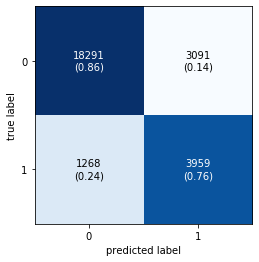

In [347]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, show_normed = True);